Import fastai

In [2]:

from fastai.vision.all import *


In [3]:
path = '/imagenet/ILSVRC2012'
dls = ImageDataLoaders.from_folder(path, valid='val', 
    item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))
    

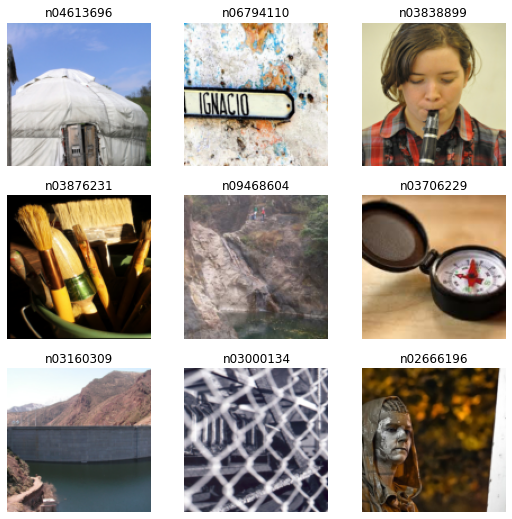

In [4]:
dls.show_batch()

In [5]:
def cornet_z_block(in_channels, out_channels, kernel_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                  stride=stride, padding=kernel_size // 2),
        nn.ReLU(inplace=True), # TODO: Find out what this does
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # Magic Numbers!
        Identity()
    )

cornet_z = nn.Sequential(
    cornet_z_block(3, 64, kernel_size=7, stride=2),
    cornet_z_block(64, 128),
    cornet_z_block(128, 256),
    cornet_z_block(256, 512),
    nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(512, 1000),
        Identity()
    )
)

In [6]:
learner = Learner(dls, cornet_z, metrics=accuracy)
learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 64 x 64   
Conv2d                                    9472       True      
ReLU                                                           
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     64 x 128 x 32 x 32  
Conv2d                                    73856      True      
ReLU                                                           
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     64 x 256 x 16 x 16  
Conv2d                                    295168     True      
ReLU                                               

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,4.352457,4.415486,0.173560,2:15:04
1,3.924991,3.970082,0.232240,2:06:21
2,3.605310,3.604761,0.281240,2:06:13
3,3.211935,3.264600,0.332600,2:06:12
4,2.971258,3.130819,0.357000,2:06:18
